[REference Link](https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
air = pd.read_csv(r"C:\Users\Urvashi\Desktop\New folder\Urvashi\Datasets\AirPassengers.csv ", index_col= "Month", parse_dates= ["Month"])

In [3]:
air.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [4]:
air.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
#Passengers    144 non-null int64
dtypes: int64(1)
memory usage: 2.2 KB


In [5]:
%matplotlib inline

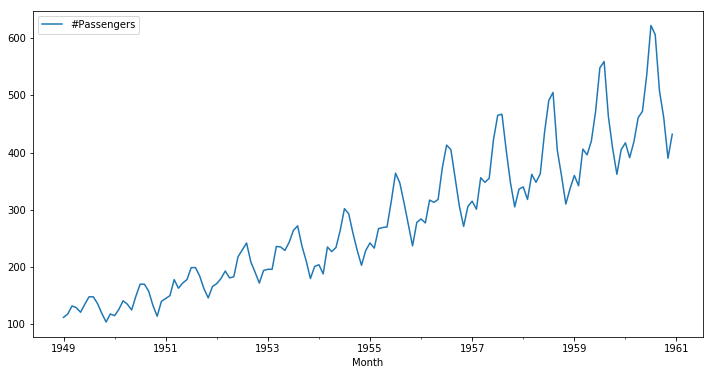

In [6]:
air.plot(figsize = (12,6))

So we can see a trend that the no. of passengers is going upwards except some seasonal variations

It is clearly evident that there is an overall increasing trend in the data along with some seasonal variations. However, it might not always be possible to make such visual inferences (we’ll see such cases later). So, more formally, we can check stationarity using the following:

* **Plotting Rolling Statistics**: We can plot the moving average or moving variance and see if it varies with time. By moving average/variance I mean that at any instant ‘t’, we’ll take the average/variance of the last year, i.e. last 12 months. But again this is more of a visual technique.


* **Dickey-Fuller Test**: This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. **If the ‘absolute value of Test Statistic’ is more than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary.**

We can define the statistic in following way as well, however, we define a function for this, to avoid writing reppetitive codes

* rolling_mean = pd.rolling_mean(air["#Passengers"], window= 12)
* rolling_std = pd.rolling_std(air["#Passengers"], window= 12)

* Alternative Synatx : rolling_mean = air["#Passengers"].rolling(window = 3, center = False).mean()

In [17]:
def Seasonality_test(timeseries):
        
        rolling_mean = pd.rolling_mean(timeseries, window= 12)
        rolling_std = pd.rolling_std(timeseries, window= 12)
        
        plt.figure(figsize=(12,6))
        orig = plt.plot(timeseries, color = "blue", label = "Original")
        mean =plt.plot(rolling_mean, color = "red", label = "Rolling Average")
        std = plt.plot(rolling_std, color = "green", label = "Rolling STD")
        plt.legend(loc = 0)
        plt.title("Rolling Mean & Standard Deviation")
        plt.show(block=False)

        from statsmodels.tsa.stattools import adfuller
        dftest = adfuller(timeseries, autolag='AIC')
        dfoutput = pd.Series(dftest[0:4],index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
        for key,value in dftest[4].items():
            dfoutput["Critical Value {}".format(key)] = value
        
        print("\n")
        print("Dickey-Fuller Test Results")
        print(dfoutput)

C:\Users\Urvashi\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Urvashi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  after removing the cwd from sys.path.


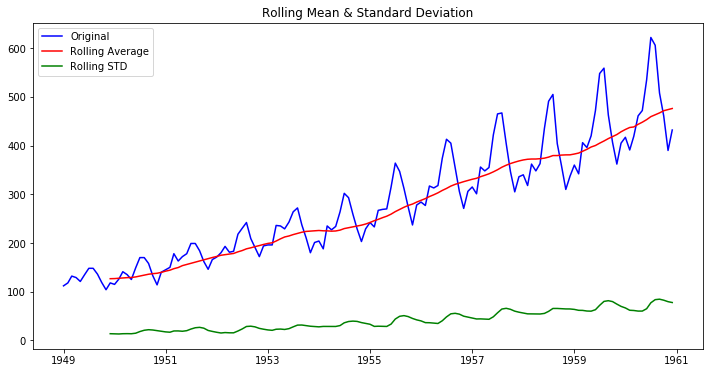



Dickey-Fuller Test Results
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value 1%               -3.481682
Critical Value 5%               -2.884042
Critical Value 10%              -2.578770
dtype: float64


In [18]:
Seasonality_test(air["#Passengers"])

Though the variation in standard deviation is small, mean is clearly increasing with time and this is not a stationary series. Also, the test statistic i.e. 0.81 lies within the critical values even for 10% test i.e. (-2.57,2.57) so we accept the null hypothesis that the ts is non-stationary.

Next, we’ll discuss the techniques that can be used to take this TS towards stationarity.

### How to make a Time Series Stationary?
Though stationarity assumption is taken in many TS models, almost none of practical time series are stationary. So statisticians have figured out ways to make series stationary, which we’ll discuss now. Actually, its almost impossible to make a series perfectly stationary, but we try to take it as close as possible.
Lets understand what is making a TS non-stationary. There are 2 major reasons behind non-stationaruty of a TS:

1. **Trend** – varying mean over time. For eg, in this case we saw that on average, the number of passengers was growing over time.

2. **Seasonality** – variations at specific time-frames. eg people might have a tendency to buy cars in a particular month because of pay increment or festivals.

The underlying principle is to model or estimate the trend and seasonality in the series and remove those from the series to get a stationary series. Then statistical forecasting techniques can be implemented on this series. The final step would be to convert the forecasted values into the original scale by applying trend and seasonality constraints back.
Note: I’ll be discussing a number of methods. Some might work well in this case and others might not. But the idea is to get a hang of all the methods and not focus on just the problem at hand.
Let’s start by working on the trend part.

### Estimating & Eliminating Trend
One of the first tricks to reduce trend can be transformation. For example, in this case we can clearly see that the there is a significant positive trend. So we can apply transformation which penalize higher values more than smaller values. These can be taking a log, square root, cube root, etc. Lets take a **log transform** here for simplicity:

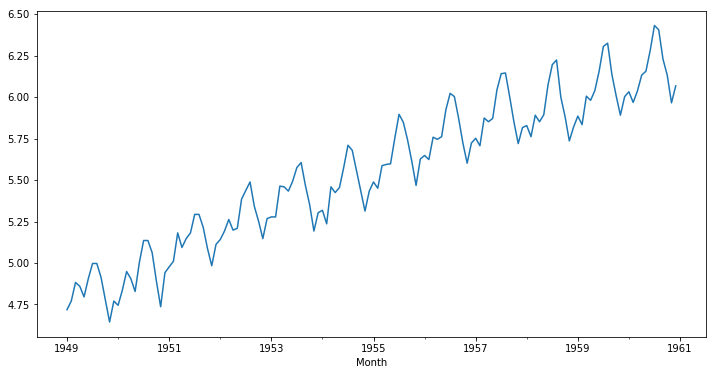

In [20]:
import numpy as np
air_log = np.log(air["#Passengers"])
air_log.plot(figsize= (12,6))

### How to remove this trend from the series?

1. Aggregation – taking average for a time period like monthly/weekly averages
2. Smoothing – taking rolling averages
3. Polynomial Fitting – fit a regression model

## Removing Trend : Using **Smoothing** Technique

### Method1 = Moving Average

##### Here we do smoothing by taking DIfference of Log TimeSeries from Rolling Mean Series and then doing Seasonality test after removing seasonality

In this approach, we take average of ‘k’ consecutive values depending on the frequency of time series. Here we can take the average over the past 1 year, i.e. last 12 values

C:\Users\Urvashi\Miniconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  """Entry point for launching an IPython kernel.


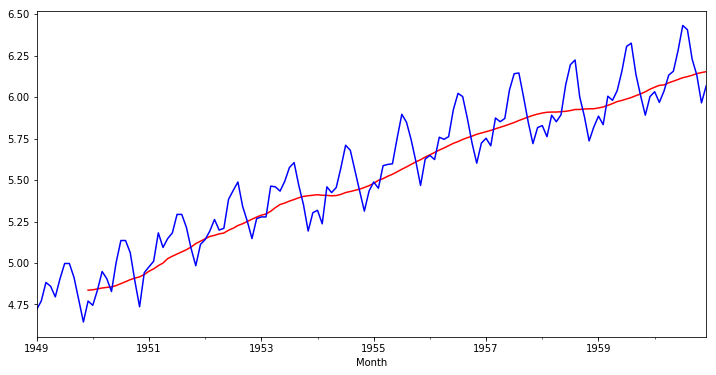

In [8]:
rolling_mean_log = pd.rolling_mean(air_log, window= 12)
rolling_mean_log.plot(figsize= (12,6), color = "red")
air_log.plot(color = "blue")

In [137]:
# Even in the above rolling_mean series, we can find presence of a trend

Since we are defining moving_avg by taking mean of 12 observations, the values aren't defined for first 11 observations, so lets drop those observations

In [108]:
print(air_log.shape)
print(rolling_mean_log.shape)

(144,)
(144,)


**Smoothening the series by taking difference of the actual series i.e. air_log and the moving average series.**

In [9]:
log_moving_avg_diff = air_log - rolling_mean_log
log_moving_avg_diff.dropna(inplace= True)
log_moving_avg_diff.shape

(133,)

C:\Users\Urvashi\Miniconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Urvashi\Miniconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  after removing the cwd from sys.path.


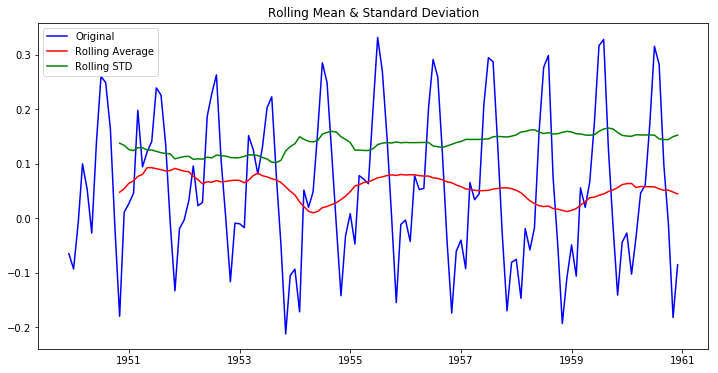



Dickey-Fuller Test Results
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value 1%               -3.486535
Critical Value 5%               -2.886151
Critical Value 10%              -2.579896
dtype: float64


In [10]:
Seasonality_test(log_moving_avg_diff)

This looks like a much better series. The rolling values appear to be varying slightly but there is no specific trend. Also, the absolute value of test statistic is more than the 5% critical values (-2.88,2.88) so **we can say with 95% confidence that this is a stationary series.**


However, a drawback in this particular approach is that the time-period has to be strictly defined. In this case we can take yearly averages but in complex situations like forecasting a stock price, its difficult to come up with a number. So we take a ‘weighted moving average’ where more recent values are given a higher weight. 

There can be many technique for assigning weights. A popular one is exponentially weighted moving average where weights are assigned to all the previous values with a decay factor. Find details here. This can be implemented in Pandas as:

### Method2 = Exponential weighted Moving Average

#### Smoothing using difference of Log Series and Exponential weighted moving average and then doing Seasonality test after removing seasonality

Exponential smoothing is a rule of thumb technique for smoothing time series data using the exponential window function. Whereas in the simple moving average the past observations are weighted equally, exponential functions are used to assign exponentially decreasing weights to older times.

C:\Users\Urvashi\Miniconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(halflife=12,min_periods=0,adjust=True,ignore_na=False).mean()
  """Entry point for launching an IPython kernel.


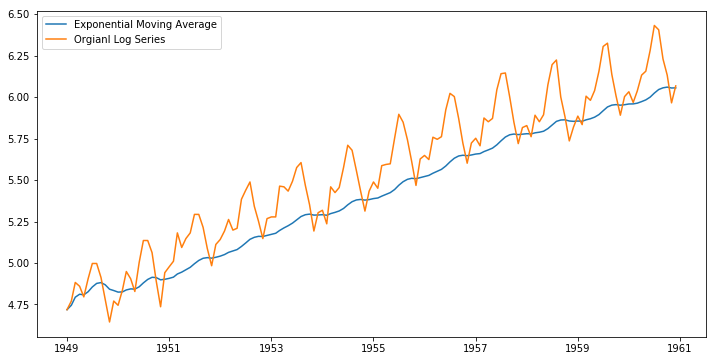

In [11]:
log_ema = pd.ewma(air_log, halflife= 12)
plt.figure(figsize= (12,6))
plt.plot(log_ema, label = "Exponential Moving Average")
plt.plot(air_log, label = "Orgianl Log Series")
plt.legend(loc = 0)

In [12]:
log_expo_moving_avg_diff = air_log - log_ema
log_expo_moving_avg_diff.shape

(144,)

C:\Users\Urvashi\Miniconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Urvashi\Miniconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  after removing the cwd from sys.path.


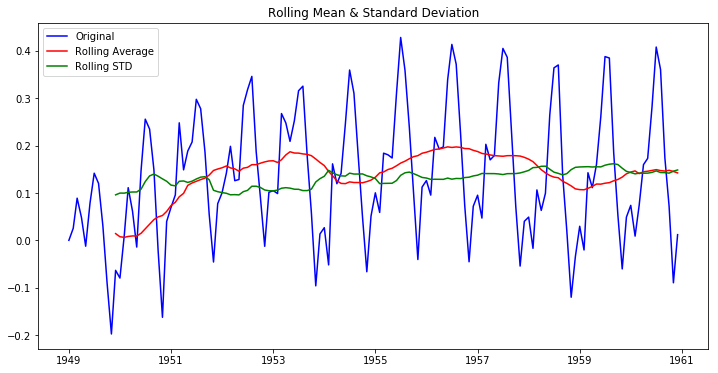



Dickey-Fuller Test Results
Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value 1%               -3.481682
Critical Value 5%               -2.884042
Critical Value 10%              -2.578770
dtype: float64


In [13]:
Seasonality_test(log_expo_moving_avg_diff)

 the absolute value of test statistic is more than the 1% critical values (-3.48,3.48) so **we can say with 99% confidence that this is a stationary series.**

### Method3 - Differencing – taking the differece with a particular time lag 

The simple trend reduction techniques discussed before don’t work in all cases, particularly the ones with high seasonality

**Differencing**

One of the most common methods of dealing with both trend and seasonality is differencing. In this technique, we take the difference of the observation at a particular instant with that at the previous instant. This mostly works well in improving stationarity. First order differencing can be done in Pandas as:

**First Order Differencing**

In [24]:
print(air_log.head())
print(air_log.shift().head())

Month
1949-01-01    4.718499
1949-02-01    4.770685
1949-03-01    4.882802
1949-04-01    4.859812
1949-05-01    4.795791
Name: #Passengers, dtype: float64
Month
1949-01-01         NaN
1949-02-01    4.718499
1949-03-01    4.770685
1949-04-01    4.882802
1949-05-01    4.859812
Name: #Passengers, dtype: float64


In [98]:
log_shift_diff = air_log - air_log.shift()
log_shift_diff.head()

Month
1949-01-01         NaN
1949-02-01    0.052186
1949-03-01    0.112117
1949-04-01   -0.022990
1949-05-01   -0.064022
Name: #Passengers, dtype: float64

In [100]:
log_shift_diff.dropna(inplace = True)

In [20]:
log_shift_diff.head()

Month
1949-02-01    0.052186
1949-03-01    0.112117
1949-04-01   -0.022990
1949-05-01   -0.064022
1949-06-01    0.109484
Name: #Passengers, dtype: float64

C:\Users\Urvashi\Miniconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Urvashi\Miniconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  after removing the cwd from sys.path.


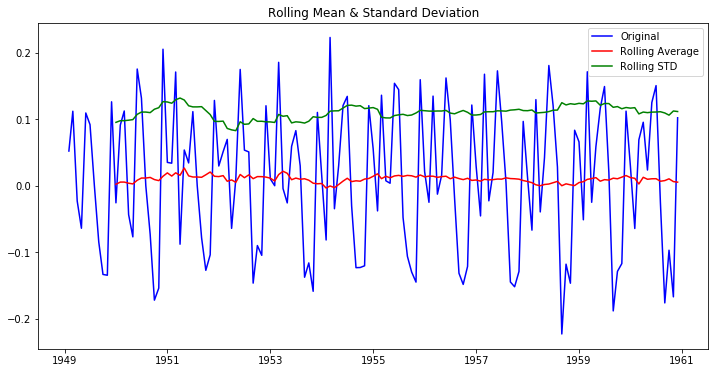



Dickey-Fuller Test Results
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value 1%               -3.482501
Critical Value 5%               -2.884398
Critical Value 10%              -2.578960
dtype: float64


In [21]:
Seasonality_test(log_shift_diff)

We can see that the mean and std variations have small variations with time. Also, the absolute value of Dickey-Fuller test statistic is more than the 10% critical values (-2.57,2.57), thus the TS is stationary with 90% confidence. We can also take second or third order differences which might get even better results in certain applications. I leave it to you to try them out.

**2nd Order Differencing**

In [25]:
log_two_shift_diff = air_log - air_log.shift(periods=2)
log_two_shift_diff.head()

Month
1949-01-01         NaN
1949-02-01         NaN
1949-03-01    0.164303
1949-04-01    0.089128
1949-05-01   -0.087011
Name: #Passengers, dtype: float64

In [26]:
log_two_shift_diff.dropna(inplace = True)

In [27]:
log_two_shift_diff.head()

Month
1949-03-01    0.164303
1949-04-01    0.089128
1949-05-01   -0.087011
1949-06-01    0.045462
1949-07-01    0.201422
Name: #Passengers, dtype: float64

C:\Users\Urvashi\Miniconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Urvashi\Miniconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  after removing the cwd from sys.path.


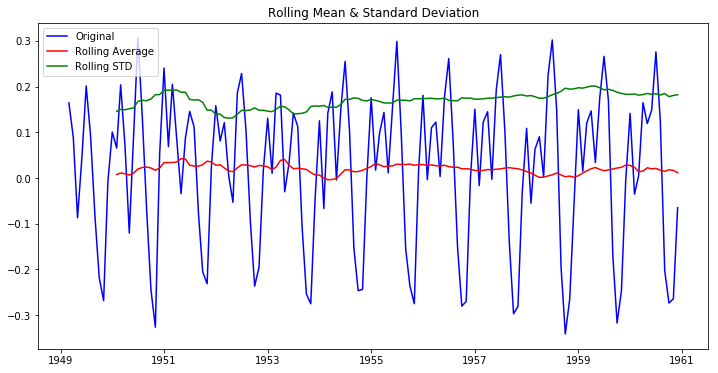



Dickey-Fuller Test Results
Test Statistic                  -3.167907
p-value                          0.021919
#Lags Used                      11.000000
Number of Observations Used    130.000000
Critical Value 1%               -3.481682
Critical Value 5%               -2.884042
Critical Value 10%              -2.578770
dtype: float64


In [28]:
Seasonality_test(log_two_shift_diff)

We can see that the mean and std variations have small variations with time. Also, the Dickey-Fuller test statistic is more than the 10% critical value, thus the TS is stationary with 95% confidence

**3rd Order Differencing**

C:\Users\Urvashi\Miniconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Urvashi\Miniconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  after removing the cwd from sys.path.


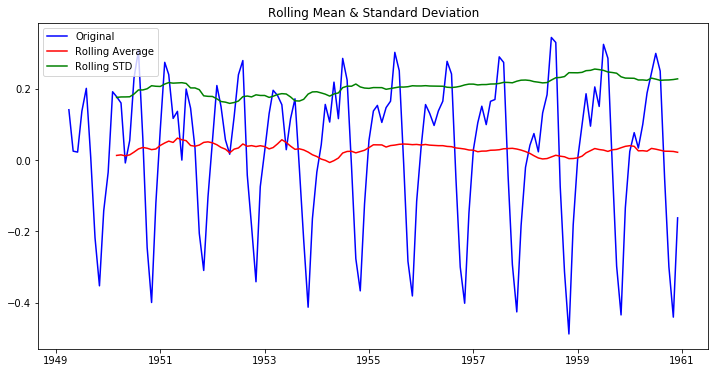



Dickey-Fuller Test Results
Test Statistic                  -2.728487
p-value                          0.069237
#Lags Used                      12.000000
Number of Observations Used    128.000000
Critical Value 1%               -3.482501
Critical Value 5%               -2.884398
Critical Value 10%              -2.578960
dtype: float64


In [29]:
log_three_shift_diff = air_log - air_log.shift(periods=3)
log_three_shift_diff.dropna(inplace = True)
Seasonality_test(log_three_shift_diff)

the Dickey-Fuller test statistic is less than the 10% critical value, thus the TS is stationary with 90% confidence

**So, here, the Second order differencing is giving the best result**

### Method4 - Decomposition  [link](https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/)

modeling both trend and seasonality and removing them from the model.

* Time series decomposition involves thinking of a series as a combination of level, trend, seasonality, and noise components.
* Decomposition provides a useful abstract model for thinking about time series generally and for better understanding problems during time series analysis and forecasting.

**Time Series Components**
A useful abstraction for selecting forecasting methods is to break a time series down into systematic and unsystematic components.

* Systematic: Components of the time series that have consistency or recurrence and can be described and modeled.
* Non-Systematic: Components of the time series that cannot be directly modeled.
A given time series is thought to consist of three systematic components including level, trend, seasonality, and one non-systematic component called noise.

These components are defined as follows:

* Level: The average value in the series.
* Trend: The increasing or decreasing value in the series.
* Seasonality: The repeating short-term cycle in the series.
* Noise: The random variation in the series.

Combining Time Series Components
A series is thought to be an aggregate or combination of these four components.

All series have a level and noise. The trend and seasonality components are optional.

**It is helpful to think of the components as combining either additively or multiplicatively.**

* Additive Model: An additive model suggests that the components are added together as follows:


y(t) = Level + Trend + Seasonality + Noise

An additive model is linear where changes over time are consistently made by the same amount.

A linear trend is a straight line.

A linear seasonality has the same frequency (width of cycles) and amplitude (height of cycles).

* Multiplicative Model : A multiplicative model suggests that the components are multiplied together as follows:


y(t) = Level * Trend * Seasonality * Noise

A multiplicative model is nonlinear, such as quadratic or exponential. Changes increase or decrease over time.

A nonlinear trend is a curved line.

A non-linear seasonality has an increasing or decreasing frequency and/or amplitude over time.



**Automatic Time Series Decomposition**
There are methods to automatically decompose a time series.

The **statsmodels library** provides an implementation of the naive, or classical, decomposition method in a function called seasonal_decompose(). 

* It requires that you specify whether the model is additive or multiplicative.

* Both will produce a result and you must be careful to be critical when interpreting the result. A review of a plot of the time series and some summary statistics can often be a good start to get an idea of whether your time series problem looks additive or multiplicative.

* The seasonal_decompose() function returns a result object. The result object contains arrays to access four pieces of data from the decomposition.

* For example, the snippet below shows how to decompose a series into trend, seasonal, and residual components assuming an additive model.

* The result object provides access to the trend and seasonal series as arrays. It also provides access to the residuals, which are the time series after the trend, and seasonal components are removed. Finally, the original or observed data is also stored.


In [31]:
# from statsmodels.tsa.seasonal import seasonal_decompose
# series = ...
# result = seasonal_decompose(series, model='additive')
# print(result.trend)
# print(result.seasonal)
# print(result.resid)
# print(result.observed)

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose_series = seasonal_decompose(air_log,model= "additive")

trend = decompose_series.trend
seasonal = decompose_series.seasonal
residual = decompose_series.resid

print(trend.head(7))
print(seasonal.head(2))
print(residual.head(7))

Month
1949-01-01        NaN
1949-02-01        NaN
1949-03-01        NaN
1949-04-01        NaN
1949-05-01        NaN
1949-06-01        NaN
1949-07-01    4.83728
Name: #Passengers, dtype: float64
Month
1949-01-01   -0.085815
1949-02-01   -0.114413
Name: #Passengers, dtype: float64
Month
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01   -0.050884
Name: #Passengers, dtype: float64


In [43]:
#These are subplot grid parameters encoded as a single integer. 
#For example, "111" means "1x1 grid, first subplot" and "234" means "2x3 grid, 4th subplot".

#Alternative form for add_subplot(111) is add_subplot(1, 1, 1).

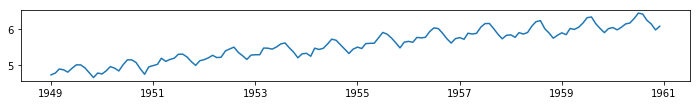

In [45]:
plt.figure(figsize=(12,6))
plt.subplot(411)
plt.plot(air_log,label = "Log Converted Original Time-Series")

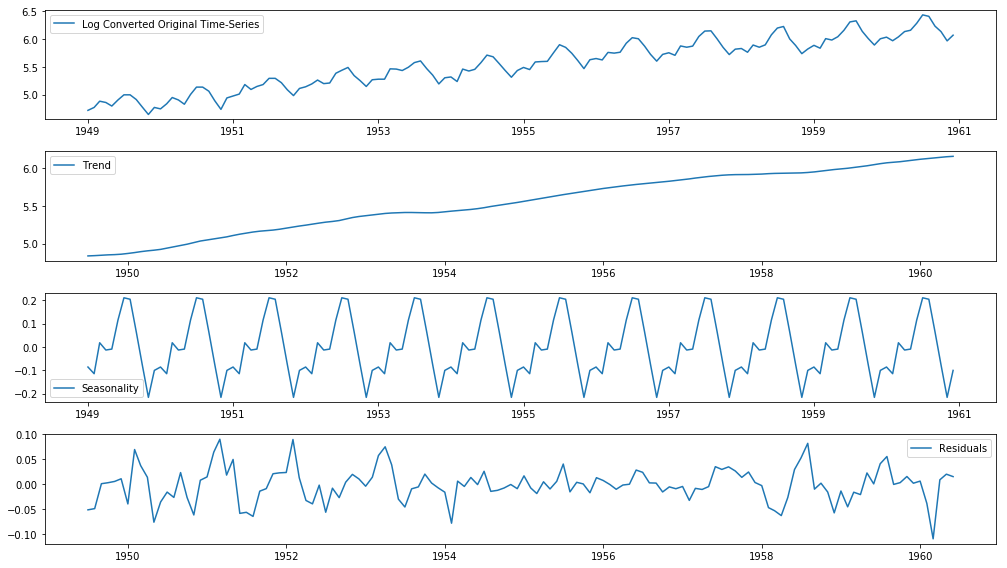

In [22]:
plt.figure(figsize=(14,8))
plt.subplot(411)
plt.plot(air_log,label = "Log Converted Original Time-Series")
plt.legend(loc = 0)

plt.subplot(412)
plt.plot(trend,label = "Trend")
plt.legend(loc = 0)

plt.subplot(413)
plt.plot(seasonal,label = "Seasonality")
plt.legend(loc = 0)

plt.subplot(414)
plt.plot(residual,label = "Residuals")
plt.legend(loc = 0)
plt.tight_layout()


Here we can see that the trend, seasonality are separated out from data and we can model the residuals. **Lets check stationarity of residuals:**

C:\Users\Urvashi\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Urvashi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  after removing the cwd from sys.path.


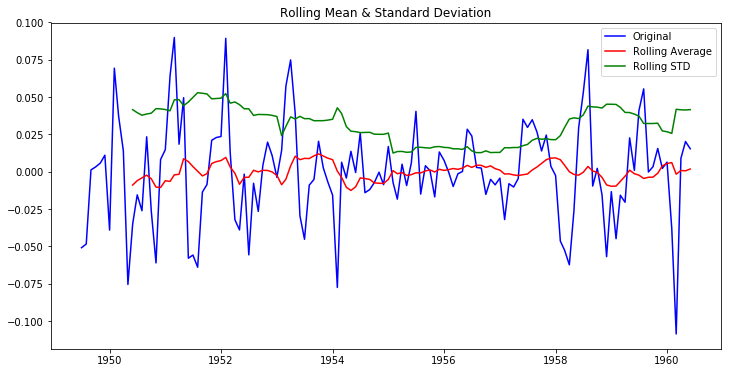

MissingDataError: exog contains inf or nans

In [25]:
Seasonality_test(residual)

In [55]:
# it is giving error due to nan values

C:\Users\Urvashi\Miniconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Urvashi\Miniconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  after removing the cwd from sys.path.


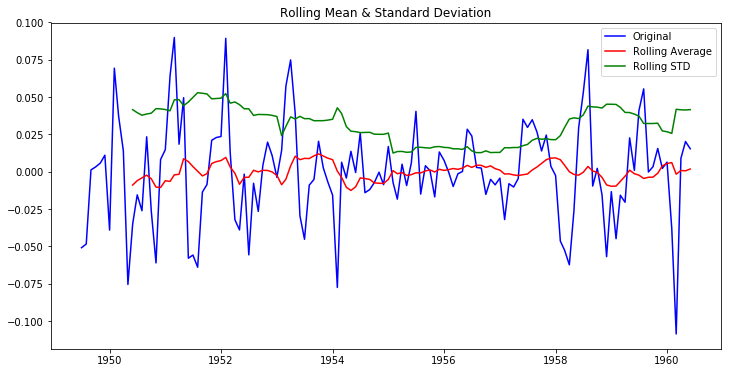



Dickey-Fuller Test Results
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value 1%             -3.485122e+00
Critical Value 5%             -2.885538e+00
Critical Value 10%            -2.579569e+00
dtype: float64


In [56]:
Seasonality_test(residual.dropna())

The Dickey-Fuller test statistic (absolute value i.e. 6.33) is significantly more than the 1% critical value. So this TS is very close to stationary. You can try advanced decomposition techniques as well which can generate better results. Also, you should note that converting the residuals into original values for future data in not very intuitive in this case.

### Forecasting a Time Series

**We saw different techniques and all of them worked reasonably well for making the TS stationary. Lets make model on the TS after differencing as it is a very popular technique**. Also, its relatively easier to add noise and seasonality back into predicted residuals in this case. Having performed the trend and seasonality estimation techniques, there can be two situations:

1. A strictly stationary series with no dependence among the values. This is the easy case wherein we can model the residuals as white noise. But this is very rare.
2. A series with significant dependence among values. In this case we need to use some statistical models like ARIMA to forecast the data.

Let me give you a brief introduction to ARIMA. I won’t go into the technical details but you should understand these concepts in detail if you wish to apply them more effectively. ARIMA stands for Auto-Regressive Integrated Moving Averages. The ARIMA forecasting for a stationary time series is nothing but a linear (like a linear regression) equation. The predictors depend on the parameters (p,d,q) of the ARIMA model:

1. **Number of AR (Auto-Regressive) terms (p)**: AR terms are just lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).
2. **Number of MA (Moving Average) terms (q)**: MA terms are lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.
3. **Number of Differences (d)**: These are the number of nonseasonal differences, i.e. in this case we took the first order difference. So either we can pass that variable and put d=0 or pass the original variable and put d=1. Both will generate same results.

An importance concern here is how to determine the value of ‘p’ and ‘q’. We use two plots to determine these numbers. Lets discuss them first.

1. **Autocorrelation Function (ACF)**: It is a measure of the correlation between the the TS with a lagged version of itself. For instance at lag 5, ACF would compare series at time instant ‘t1’…’t2’ with series at instant ‘t1-5’…’t2-5’ (t1-5 and t2 being end points).
2. **Partial Autocorrelation Function (PACF)**: This measures the correlation between the TS with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons. Eg at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4.

#### The ACF and PACF plots for the TS after differencing can be plotted as:

#### Note : We are using stationary time series created using first order differencing i.e. log_shift_diff series



In [57]:
from statsmodels.tsa.stattools import acf,pacf

In [65]:
lag_acf = acf(log_shift_diff,nlags=20)
lag_pacf = pacf(log_shift_diff,nlags=20,method= "ols")

In [66]:
lag_acf

array([ 1.        ,  0.19975134, -0.12010433, -0.15077204, -0.32207432,
       -0.08397453,  0.02577843, -0.11096075, -0.33672146, -0.11558631,
       -0.10926704,  0.20585223,  0.84142998,  0.21508704, -0.13955394,
       -0.11599576, -0.27894284, -0.05170646,  0.01245814, -0.1143576 ,
       -0.33717439])

In [67]:
lag_pacf

array([ 1.        ,  0.20081508, -0.17368194, -0.09901213, -0.33527437,
        0.00872185, -0.07990745, -0.21923579, -0.5421352 , -0.22848913,
       -0.64775301, -0.53828661,  0.59971786,  0.29995642, -0.10992268,
        0.14878637, -0.00321881,  0.01892684, -0.14268478,  0.07089814,
       -0.15566902])

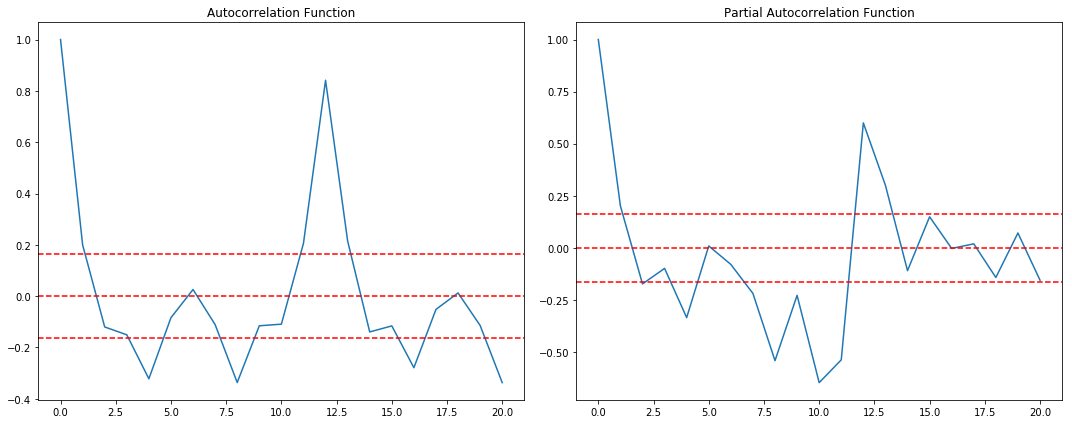

In [69]:
# Plot ACF

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(lag_acf)
plt.axhline(y = 0,linestyle = "--",color = "red")
plt.axhline(y = -1.96/np.sqrt(len(air_log)),linestyle = "--",color = "red")
plt.axhline(y = 1.96/np.sqrt(len(air_log)),linestyle = "--",color = "red")
plt.title("Autocorrelation Function")

plt.subplot(1,2,2)
plt.plot(lag_pacf)
plt.axhline(y = 0,linestyle = "--",color = "red")
plt.axhline(y = -1.96/np.sqrt(len(air_log)),linestyle = "--",color = "red")
plt.axhline(y = 1.96/np.sqrt(len(air_log)),linestyle = "--",color = "red")
plt.title("Partial Autocorrelation Function")
plt.tight_layout()

In this plot, the two dotted lines on either sides of 0 are the confidence interevals. These can be used to determine the ‘p’ and ‘q’ values as:

1. p – The lag value where the PACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case p=2.
2. q – The lag value where the ACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case q=2.

Now, lets make 3 different ARIMA models considering individual as well as combined effects. I will also print the RSS for each. Please note that here RSS is for the values of residuals and not actual series.

We need to load the ARIMA model first:

**The p,d,q values can be specified using the order argument of ARIMA which take a tuple (p,d,q). Let model the 3 cases:**

**Note : p,d,q here are values for AR,I and MA i.e. 
* p tells about no. of auto-lags i.e. AR parameter
* d is differencing. If d=0:  yt  =  Yt, If d=1:  yt  =  Yt - Yt-1
* q is the MA paramter

In [70]:
from statsmodels.tsa.arima_model import ARIMA

[Useful Link](https://people.duke.edu/~rnau/411arim.htm)

#### AR Model : so we will put only parameter of AR model i.e. p & will take paramter of MA i.e. "q" constant

Text(0.5,1,'1.5023033686758773')

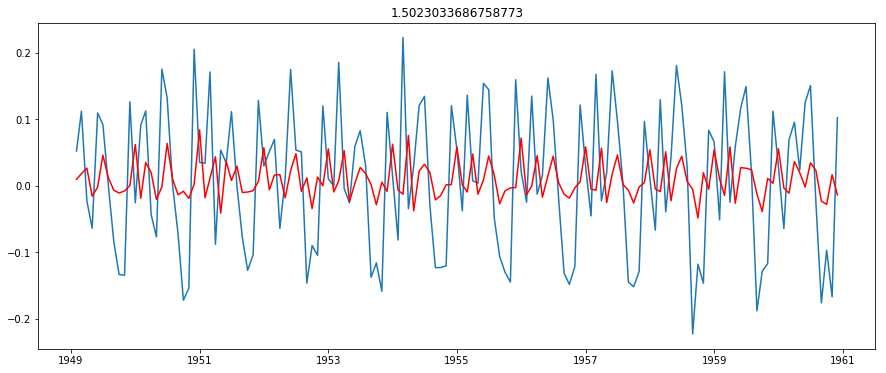

In [123]:
# AR Model : so we will put only parameter of AR model i.e. p & will take paramter of MA i.e. "q" constant

model = ARIMA(air_log,order=(2,1,0)) # here we are using log of the original time series.
results_AR = model.fit(disp=-1)

plt.figure(figsize= (15,6))
plt.plot(log_shift_diff) # here we are plotting time_series without seasonality i.e. log_difference
plt.plot(results_AR.fittedvalues,color='red')
RSS = ((results_AR.fittedvalues-log_shift_diff)**2).sum() # Residual Sum of Squares
plt.title("{}".format(RSS))


### MA model : so we will put only parameter of MA model i.e. q & will take paramter of AR i.e. "p" constant

Text(0.5,1,'1.472140134745266')

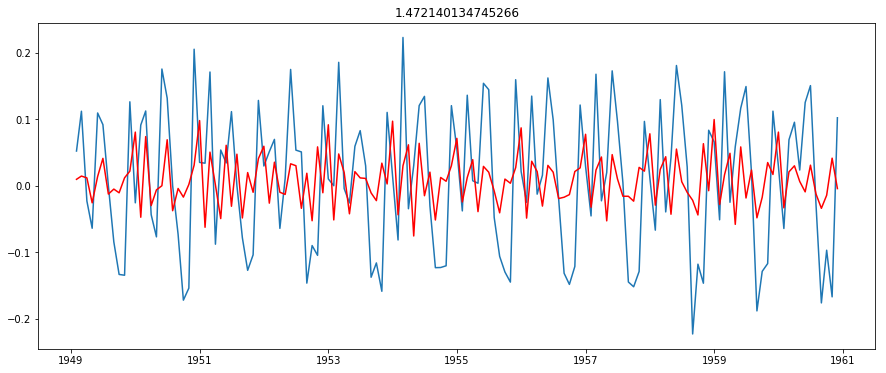

In [122]:
# MA model : so we will put only parameter of MA model i.e. q & will take paramter of AR i.e. "p" constant

model = ARIMA(air_log,order= (0,1,2)) # here we are using log of the original time series.
results_MA = model.fit(disp=-1)

plt.figure(figsize=(15,6))
plt.plot(log_shift_diff) # here we are plotting time_series without seasonality i.e. log_difference
plt.plot(results_MA.fittedvalues,color = "red")
RSS = ((results_MA.fittedvalues-log_shift_diff)**2).sum() # Residual Sum of Squares
plt.title("{}".format(RSS))

### Combined Model : here, we will put values of both p and q

Text(0.5,1,'1.0291520067795843')

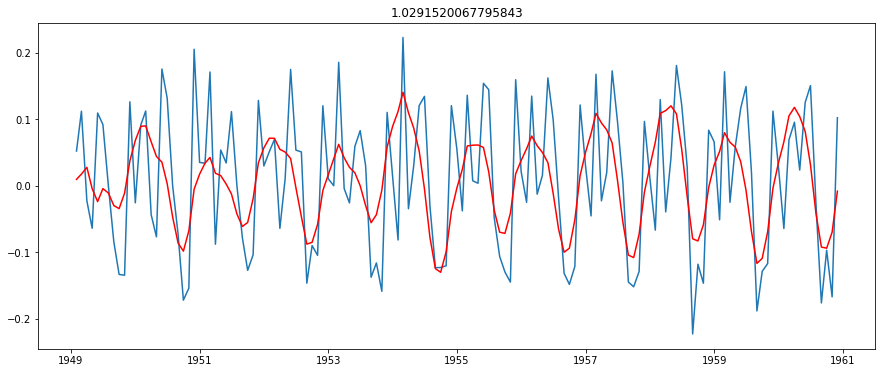

In [124]:
model = ARIMA(air_log, order=(2, 1, 2))   # here we are using log of the original time series.
results_ARIMA = model.fit(disp=-1)

plt.figure(figsize= (15,6))
plt.plot(log_shift_diff) # here we are plotting time_series without seasonality i.e. log_difference
plt.plot(results_ARIMA.fittedvalues, color='red')
RSS = ((results_ARIMA.fittedvalues-log_shift_diff)**2).sum() # Residual Sum of Squares
plt.title("{}".format(RSS))

Here we can see that the AR and MA models have almost the same RSS but combined is significantly better. Now, we are left with 1 **last step, i.e. taking these values back to the original scale.**

In [125]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print( predictions_ARIMA_diff.head())

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023889
dtype: float64


Notice that these start from ‘1949-02-01’ and not the first month. Why? This is because we took a lag by 1 and first element doesn’t have anything before it to subtract from. The way to convert the differencing to log scale is to add these differences consecutively to the base number. An easy way to do it is to first determine the cumulative sum at index and then add it to the base number. The cumulative sum can be found as:

In [126]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print( predictions_ARIMA_diff_cumsum.head())

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
dtype: float64


You can quickly do some back of mind calculations using previous output to check if these are correct. Next we’ve to add them to base number. For this lets create a series with all values as base number and add the differences to it. This can be done as:

In [127]:
predictions_ARIMA_log = pd.Series(air_log.ix[0], index=air_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773240
1949-05-01    4.768720
dtype: float64

Here the first element is base number itself and from thereon the values cumulatively added. Last step is to take the exponent and compare with the original series.

Text(0.5,1,'RMSE: 90.1051')

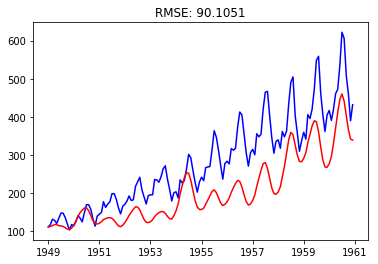

In [128]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(air,color = "blue")
plt.plot(predictions_ARIMA,color = "red")
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-air["#Passengers"])**2)/len(air["#Passengers"])))